In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
cd '/content/drive/MyDrive/4조/머신러닝과제/딥러닝과제/Pokemon'

/content/drive/MyDrive/4조/머신러닝과제/딥러닝과제/Pokemon


In [35]:
# cd '/content/drive/MyDrive/딥러닝 과제/Pokemon/Fake'

In [36]:
!ls

acc_basic_loss_plot.png  loss_plot.png	       splitted
baseline.pt		 Pokemon.ipynb	       VGG16_Acc_plot.png
GoogLeNet_loss_plot.png  SET_UP_Pokemon.ipynb


In [37]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import random
import cv2
import glob
from PIL import Image
import PIL.ImageOps
import torch
import os
import random
import pandas as pd
import pickle

## Train, Validation Dataset

In [38]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
BATCH_SIZE = 50
EPOCH = 300

In [39]:
## random number
# 출처 : https://jsc5565.tistory.com/21
# 출처 : https://hoya012.github.io/blog/reproducible_pytorch/
# 출처(Data Loader) : https://discuss.pytorch.org/t/shuffle-issue-in-dataloader-how-to-get-the-same-data-shuffle-results-with-fixed-seed-but-different-network/45357/9
# 출처 : https://velog.io/@jhlee508/Code-Reproduction%EC%9D%84-%EC%9C%84%ED%95%9C-Seed-%EA%B3%A0%EC%A0%95-feat.-OS-Numpy-Random-PyTorch-Tensorflow
# pytorch random seed
random_seed = 2022
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)
os.environ["PYTHONHASHSEED"] = str(random_seed)

In [40]:
# print("Current CPU random seed", torch.initial_seed())
# print("Current CUDA ramdom seed", torch.cuda.initial_seed())

## Transfer Learning을 위한 준비

In [41]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

data_transforms = {
    'train': transforms.Compose([transforms.Resize([256,256]), 
        transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),  
        transforms.RandomCrop(224), transforms.ToTensor(), 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) ]),
    
    'val': transforms.Compose([transforms.Resize([256,256]),  
        transforms.RandomCrop(224), transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) ])
}

### Seed 설정

In [42]:
def set_seed(seed):
  torch.manual_seed(random_seed)
  torch.cuda.manual_seed(random_seed)
  torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(random_seed)
  random.seed(random_seed)
  os.environ["PYTHONHASHSEED"] = str(random_seed)

In [43]:
set_seed(2022)
data_dir = './splitted' 
image_datasets = {x: ImageFolder(root=os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'val']} 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last = True, worker_init_fn=np.random.seed(2022)) for x in ['train', 'val']} 
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [44]:
directory = "./splitted/train"
labels = os.listdir(directory)
class_num = len(labels)
print(labels)

['Abra', 'Aerodactyl', 'Arcanine', 'Alakazam', 'Arbok', 'Articuno', 'Alolan Sandslash', 'Golduck', 'Gastly', 'Geodude', 'Grimer', 'Goldeen', 'Golbat', 'Graveler', 'Gyarados', 'Gloom', 'Golem', 'Growlithe', 'Gengar', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon']


### 이미지 확인하기

In [45]:
set_seed(2022)
for (X_train, y_train) in dataloaders['train']:
 print('X_train:', X_train.size( ), 'type:', X_train.type( ))
 print('y_train:', y_train.size( ), 'type:', y_train.type( ))
 break
# X _train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
# y _train: torch.Size([32]) type: torch.LongTensor

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


X_train: torch.Size([50, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([50]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

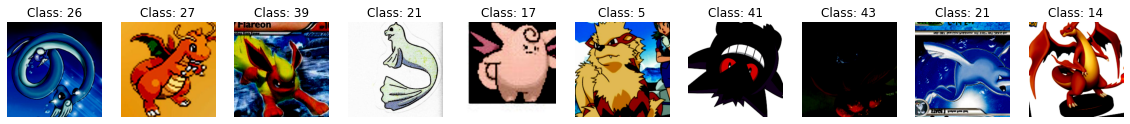

In [46]:
pltsize = 2
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
 plt.subplot(1, 10, i + 1)
 plt.axis('off')
 plt.imshow(np.transpose(X_train[i],(1, 2, 0)))
 plt.title('Class: ' + str(y_train[i].item( )))

### 데이터 확인하기

In [47]:
first_batch = dataloaders['train'].__iter__().__next__()
print('{:15s} | {:<25s} | {}'.format('name', 'type', 'size'))
print('{:15s} | {:<25s} | {}'.format('Num of Total', '', len(image_datasets['train'])))
print('{:15s} | {:<25s} | {}'.format('Num of Batch', '', len(dataloaders['train'])))
print('{:15s} | {:<25s} | {}'.format('first_batch', str(type(first_batch)), len(first_batch)))
print('{:15s} | {:<25s} | {}'.format('first_batch[0]', str(type(first_batch[0])), first_batch[0].shape))
print('{:15s} | {:<25s} | {}'.format('first_batch[1]', str(type(first_batch[1])), first_batch[1].shape))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


name            | type                      | size
Num of Total    |                           | 7002
Num of Batch    |                           | 140
first_batch     | <class 'list'>            | 2
first_batch[0]  | <class 'torch.Tensor'>    | torch.Size([50, 3, 224, 224])
first_batch[1]  | <class 'torch.Tensor'>    | torch.Size([50])


## Pre-Trained Model 불러오기

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

In [49]:
from torchvision import models
 
resnet = models.resnet50(pretrained=True)  
num_ftrs = resnet.fc.in_features   
resnet.fc = nn.Linear(num_ftrs, class_num) 
model = resnet.to(DEVICE)
 
criterion = nn.CrossEntropyLoss() 
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)
 
# from torch.optim import lr_scheduler
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) 

## Pre-Trained Model의 일부 Layer Freeze 하기

In [50]:
for name,module in resnet.named_children():
  print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [51]:
ct = 0 
for child in resnet.children():
    ct += 1
    if ct < 6: 
        for param in child.parameters():
            param.requires_grad = False

### Early Stopping

In [52]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0.1, path='checkpoint.pt', val_accuracy_min = 0):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = val_accuracy_min
        self.early_stop = False
        self.val_accuracy_min = val_accuracy_min
        self.delta = delta
        self.path = path


    def __call__(self, val_accracy, model):

        score = val_accracy

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_accracy, model)
            
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_accracy, model)
            self.counter = 0

    def save_checkpoint(self, val_accracy, model):
        '''validation accuracy가 증가하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation increased ({self.val_accuracy_min:.6f} --> {val_accracy:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_accuracy_min = val_accracy

## Transfer Learning 모델 학습과 검증을 위한 함수

In [53]:
import time

In [54]:
def train_resnet(model, criterion, optimizer, num_epochs=10, patience = 1, BATCH_SIZE = BATCH_SIZE):
  
    # 모델이 학습되는 동안 trainning loss를 track
    # train_losses = []
    # 모델이 학습되는 동안 validation loss를 track
    # valid_losses = []
    # 모델이 학습되는 동안 trainning accracy를 track
    # train_acces = []
    # 모델이 학습되는 동안 vaildation accuracy를 track
    # val_acces = []
    # epoch당 average training loss를 track
    avg_train_losses = []
    # epoch당 average validation loss를 track
    avg_valid_losses = []


    #####################################
    ### pkl 파일 확인하여 중간 값을 넣어야 함 ###
    #####################################

    avg_train_accuracies = []
    avg_valid_accuracies = []

    dir = '/content/drive/MyDrive/딥러닝 과제/Pokemon'
    files = os.listdir(dir)

    for file in files:
      if file == 'acc_Trained_RESNet.pkl':
        print("catch " + file)
        acc_df = pd.read_pickle(dir + '/' + file)
        avg_train_accuracies = acc_df.train_accuracy.to_list()
        avg_valid_accuracies = acc_df.val_accuracy.to_list()

    if len(avg_valid_accuracies) == 0:
      val_accracy_check = 0
    else:
      val_accracy_check = max(avg_valid_accuracies)


    # early_stopping object의 초기화
    print('Minimum val accuracy : {:.6f}\n'.format(val_accracy_check))
    early_stopping = EarlyStopping(patience = patience, verbose = True,
                                   path = '/content/drive/MyDrive/딥러닝 과제/Pokemon/acc_Trained_RESNet.pt',
                                   val_accuracy_min = val_accracy_check)
    
    for epoch in range(1, num_epochs+1):

        since = time.time()
                                      
        for phase in ['train', 'val']: 
            if phase == 'train': 
                model.train() 
            else:
                model.eval()     
 
            running_loss = 0.0  
            running_corrects = 0  
 
            set_seed(2022)
            for inputs, labels in dataloaders[phase]: 
                inputs = inputs.to(DEVICE)  
                labels = labels.to(DEVICE)  
                
                optimizer.zero_grad() 
                
                with torch.set_grad_enabled(phase == 'train'):  
                    outputs = model(inputs)  
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)  
    
                    if phase == 'train':   
                        loss.backward()
                        optimizer.step()
 
                running_loss += loss.item() * inputs.size(0)  
                running_corrects += torch.sum(preds == labels.data)  
            # if phase == 'train':  
            #     scheduler.step()
 
            epoch_loss = running_loss/(len(dataloaders[phase]) * BATCH_SIZE)  
            epoch_acc = running_corrects.double()/(len(dataloaders[phase]) * BATCH_SIZE)
            
            # print('Acc: {:.4f}'.format(running_corrects.double()))
 
            if phase == 'train':
              train_loss = epoch_loss
              train_accuracy = (epoch_acc.cpu().detach().numpy() + 0) * 100
              avg_train_accuracies.append(train_accuracy)
            else :
              val_loss = epoch_loss
              val_accuracy = (epoch_acc.cpu().detach().numpy() + 0) * 100
              avg_valid_accuracies.append(val_accuracy)
        


        epoch_len = len(str(num_epochs))
        print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
            f'train_loss: {train_loss:.5f} ' +
            f'train_accuracy: {train_accuracy:.5f} ' +
            f'valid_loss: {val_loss:.5f} '  + 
            f'valid_accuracy: {val_accuracy:.5f}')
        
        print(print_msg)
        # print('running_Loss: {:.4f} running_Acc: {:.4f}'.format(running_loss, running_corrects.double()))
        # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
        # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
        early_stopping(val_accuracy, model)

        time_elapsed = time.time() - since

        if time_elapsed // 60 < 1:
          time.sleep(15)                

        acc_df = pd.DataFrame({"train_accuracy" : avg_train_accuracies,
                       "val_accuracy" : avg_valid_accuracies})
        
        
        acc_df.to_pickle('/content/drive/MyDrive/딥러닝 과제/Pokemon/acc_Trained_RESNet.pkl')

        print("DataFrame 저장 완료!")       

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # best model이 저장되어있는 last checkpoint를 로드한다.
    model.load_state_dict(torch.load('/content/drive/MyDrive/딥러닝 과제/Pokemon/acc_Trained_RESNet.pt'))
    print("Model 로드 완료!")
    return model, avg_train_accuracies, avg_valid_accuracies

## 모델 불러오기

In [55]:
### 이전 저장된 pt 파일이 있으면 pt 파일을 불러온다. ###
dir = '/content/drive/MyDrive/딥러닝 과제/Pokemon'
files = os.listdir(dir)

for file in files:
  if file == 'acc_Trained_RESNet.pt':
    print("catch acc_Trained_RESNet.pt")
    model.load_state_dict(torch.load(dir + '/' + file))
    print(model.load_state_dict(torch.load(dir + '/' + file)))

catch acc_Trained_RESNet.pt
<All keys matched successfully>


## 모델 학습(이어서)

In [56]:
# early stopping patience;
patience = 30
model, train_acc, valid_acc = train_resnet(resnet, criterion, optimizer_ft, num_epochs=EPOCH, patience = patience, BATCH_SIZE = BATCH_SIZE)

catch acc_Trained_RESNet.pkl
Minimum val accuracy : 92.000000



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[  1/300] train_loss: 0.04590 train_accuracy: 98.81429 valid_loss: 0.76468 valid_accuracy: 87.50000
EarlyStopping counter: 1 out of 30
DataFrame 저장 완료!
[  2/300] train_loss: 0.03401 train_accuracy: 98.91429 valid_loss: 0.80336 valid_accuracy: 88.00000
EarlyStopping counter: 2 out of 30
DataFrame 저장 완료!
[  3/300] train_loss: 0.04944 train_accuracy: 98.64286 valid_loss: 1.13750 valid_accuracy: 81.75000
EarlyStopping counter: 3 out of 30
DataFrame 저장 완료!
[  4/300] train_loss: 0.03011 train_accuracy: 99.15714 valid_loss: 0.49592 valid_accuracy: 92.75000
Validation increased (92.000000 --> 92.750000).  Saving model ...
DataFrame 저장 완료!
[  5/300] train_loss: 0.00355 train_accuracy: 99.90000 valid_loss: 0.51990 valid_accuracy: 90.50000
EarlyStopping counter: 1 out of 30
DataFrame 저장 완료!
[  6/300] train_loss: 0.02179 train_accuracy: 99.40000 valid_loss: 0.78297 valid_accuracy: 84.75000
EarlyStopping counter: 2 out of 30
DataFrame 저장 완료!
[  7/300] train_loss: 0.04608 train_accuracy: 98.71429 va

KeyboardInterrupt: ignored

## Eearly Stopping 체크포인트

In [66]:
### 이전 저장된 pt 파일이 있으면 pt 파일을 불러온다. ###
dir = '/content/drive/MyDrive/딥러닝 과제/Pokemon'
files = os.listdir(dir)

for file in files:
  if file == 'acc_Trained_RESNet.pt':
    print("catch acc_Trained_RESNet.pt")
    model.load_state_dict(torch.load(dir + '/' + file))
    print(model.load_state_dict(torch.load(dir + '/' + file)))

### acc_df 불러오기
acc_df = pd.read_pickle('/content/drive/MyDrive/딥러닝 과제/Pokemon/acc_Trained_RESNet.pkl')
train_acc = acc_df.train_accuracy.to_list()
valid_acc = acc_df.val_accuracy.to_list()

catch acc_Trained_RESNet.pt
<All keys matched successfully>


## 모델 평가를 위한 함수

In [58]:
def evaluate(model, test_loader):
  model.eval() # prep model for evaluation
  val_correct = 0
  loss = 0
  # 모델이 학습되는 동안 validation loss를 track
  valid_losses = []
  # 모델이 학습되는 동안 vaildation accuracy를 track
  # val_acces = []

  ## Gradient를 통해 파라미터 값이 업데이트되는 현상을 방지하기 위해
  ## torch.no_grad()메서드를 이용해 Gradient의 흐름을 억제합니다.
  with torch.no_grad():
    set_seed(2022)
    for data , target in  test_loader:
      # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
      data, target = data.to(DEVICE), target.to(DEVICE)
      output = model(data)
      # calculate the loss
      loss = F.cross_entropy(output, target)
      # record validation loss
      valid_losses.append(loss.item())
      pred = output.max(1, keepdim=True)[1]
      val_correct += pred.eq(target.view_as(pred)).sum().item()
  val_accuracy = 100. * val_correct / (len(test_loader) * BATCH_SIZE)
  # val_acces.append(val_accuracy)
  
  return valid_losses, val_accuracy

In [59]:
# val acc 확인
test_losses, test_accuracy = evaluate(model, dataloaders['val'])
np.average(test_losses), test_accuracy

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.49592404067516327, 92.75)

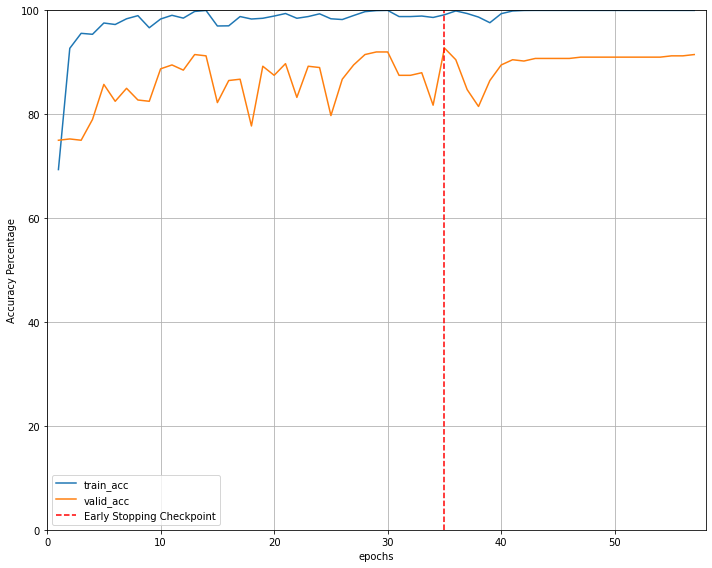

In [60]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_acc)+1),train_acc, label='train_acc')
plt.plot(range(1,len(valid_acc)+1),valid_acc,label='valid_acc')

# validation loss의 최저값 지점을 찾기
maxposs = valid_acc.index(max(valid_acc))+1
plt.axvline(maxposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('Accuracy Percentage')
plt.ylim(0, 100) # 일정한 scale
plt.xlim(0, len(train_acc)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('GoogLeNet_loss_plot.png', bbox_inches = 'tight')

## 모델 평가

### 베이스라인 모델 평가를 위한 전처리

In [61]:
set_seed(2022)
test_dataset = ImageFolder(root='./splitted/test', transform=data_transforms['val'])  
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last = True, worker_init_fn=np.random.seed(2022))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 베이스라인 모델 성능 평가하기

In [62]:
# test loss 및 accuracy을 모니터링하기 위해 list 초기화
test_loss = 0.0
class_correct = list(0. for i in range(class_num))
class_total = list(0. for i in range(class_num))


model.eval() # prep model for evaluation

# Gradient 업데이트를 하지 않음

set_seed(2022)
with torch.no_grad():
  for data, target in test_loader :
      data, target = data.to(DEVICE), target.to(DEVICE)

      if len(target.data) != BATCH_SIZE:
          break

      # forward pass: 입력을 모델로 전달하여 예측된 출력 계산
      output = model(data)
      # calculate the loss
      test_loss += F.cross_entropy(output, 
                    target, reduction='sum').item() 
      # 출력된 확률을 예측된 클래스로 변환
      # _, pred = torch.max(output, 1)
      pred = output.max(1, keepdim=True)[1]
      # 예측과 실제 라벨과 비교
      
      correct = np.squeeze(pred.eq(target.data.view_as(pred)))

      # 각 object class에 대해 test accuracy 계산
      for i in range(BATCH_SIZE):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] +=1

# calculate and print avg test loss
test_loss = test_loss/(len(test_loader) * BATCH_SIZE)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(class_num):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.4f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Loss: 0.559801

Test Accuracy of     0: 66% ( 4/ 6)
Test Accuracy of     1: 100% ( 7/ 7)
Test Accuracy of     2: 100% ( 5/ 5)
Test Accuracy of     3: 87% ( 7/ 8)
Test Accuracy of     4: 100% ( 8/ 8)
Test Accuracy of     5: 42% ( 3/ 7)
Test Accuracy of     6: 75% ( 6/ 8)
Test Accuracy of     7: 100% ( 6/ 6)
Test Accuracy of     8: 100% ( 6/ 6)
Test Accuracy of     9: 100% ( 8/ 8)
Test Accuracy of    10: 100% ( 7/ 7)
Test Accuracy of    11: 60% ( 3/ 5)
Test Accuracy of    12: 85% ( 6/ 7)
Test Accuracy of    13: 85% ( 6/ 7)
Test Accuracy of    14: 100% ( 6/ 6)
Test Accuracy of    15: 80% ( 8/10)
Test Accuracy of    16: 88% ( 8/ 9)
Test Accuracy of    17: 100% ( 6/ 6)
Test Accuracy of    18: 100% ( 9/ 9)
Test Accuracy of    19: 87% ( 7/ 8)
Test Accuracy of    20: 87% ( 7/ 8)
Test Accuracy of    21: 87% ( 7/ 8)
Test Accuracy of    22: 100% ( 7/ 7)
Test Accuracy of    23: 100% ( 8/ 8)
Test Accuracy of    24: 71% ( 5/ 7)
Test Accuracy of    25: 100% ( 7/ 7)
Test Accuracy of    26: 75% ( 

In [63]:
test_losses, test_accuracy = evaluate(model, test_loader)
np.average(test_losses), test_accuracy

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.5598014257848263, 89.0)

## Visualize Sample Test Results

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

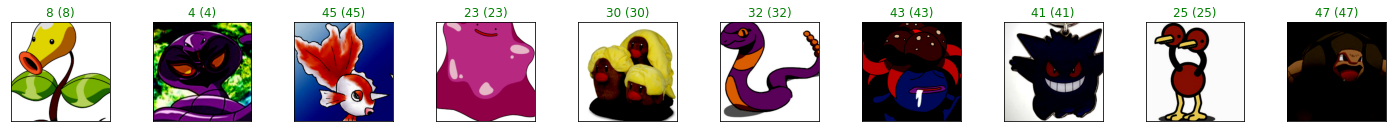

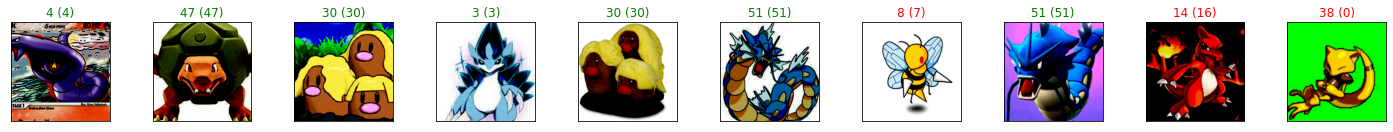

In [64]:
# obtain one batch of test images
for i in range(2):
  dataiter = iter(test_loader)
  images, labels = dataiter.next()
  images, labels = images.to(DEVICE), labels.to(DEVICE)
  # get sample outputs
  output = model(images)
  # convert output probabilities to predicted class
  _, preds = torch.max(output, 1)
  # prep images for display
  images = images.cpu().numpy()
  labels = labels.cpu().numpy()
  # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(10):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      ax.imshow(np.transpose(images[idx], (1, 2, 0)))
      ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                  color=("green" if preds[idx]==labels[idx] else "red"))